# Step Size Analysis of a Amyloid Fibril in a Thermophoretic Trap 

Demonstration of the step size analysis for a β-Amyloid (Aβ<sub>40</sub>) fibril in a thermopheretic trap imaged by the fluorescence of thioflavin T (ThT). See the **Supplementary Notes 8 and 9** for details. 

Author(s): *Martin Fränzl*

## Required packages

In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

import codecs
import os, glob
import pandas as pd

import trackpy as tp

from scipy import stats
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 18,
                     'axes.titlesize': 20,
                     'axes.labelsize': 20,
                     'axes.labelpad': 14,
                     'lines.linewidth': 3,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Path to dataset

In [8]:
path_to_data = r'C:\Folderfile' #Pathfile where the measurementsfiles (csv or h5) are
dataset = '\Set01' #how the Dataset is called

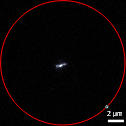

In [9]:
## Preview
from IPython.display import Image

Image(filename='Set_01.png', width=240) 

## Information about the sample preparation, experimental setup and the dataset

In [10]:
with codecs.open(path_to_data + '\Protocol.txt', 'r', encoding='utf-8') as f:
    info = f.read()               
print(info) #show the protocoll file

trapsize 15 mym

exposure time 0,01s

binning 2

EM gain 100

Ausschnitt 130 x 380

trapping power 1,5 mW

file size 1000 framws


## Useful functions

In [11]:
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [12]:
def rayleigh(x, a, sigma):
    return a*x*np.exp(-x**2/(2*sigma**2))/sigma**2

## Load the tracking data and the metadata 

The fibril was tracked using the TrackerLab.py script and the tracking data as well as the metadata was stored in HDF5 files.

In [13]:
# List all *_feature.h5 files of the dataset
for file in glob.glob(path_to_data + dataset + '*_features.h5'):
    print(os.path.basename(file))

Measurement_000_features.h5
Measurement_001_features.h5
Measurement_002_features.h5
Measurement_003_features.h5
Measurement_004_features.h5
Measurement_005_features.h5
Measurement_006_features.h5
Measurement_007_features.h5
Measurement_008_features.h5
Measurement_009_features.h5
Measurement_010_features.h5
Measurement_011_features.h5
Measurement_012_features.h5
Measurement_013_features.h5
Measurement_014_features.h5
Measurement_015_features.h5
Measurement_016_features.h5
Measurement_017_features.h5
Measurement_018_features.h5
Measurement_019_features.h5
Measurement_020_features.h5
Measurement_021_features.h5
Measurement_022_features.h5
Measurement_023_features.h5
Measurement_024_features.h5
Measurement_025_features.h5
Measurement_026_features.h5
Measurement_027_features.h5
Measurement_028_features.h5
Measurement_029_features.h5
Measurement_030_features.h5
Measurement_031_features.h5
Measurement_032_features.h5
Measurement_033_features.h5
Measurement_034_features.h5
Measurement_035_feat

### Load the metadata

In [16]:
metadata = pd.read_hdf(path_to_data + dataset + '_features.h5', 'metadata').to_dict('records')[0]
metadata

{'dimx': 126,
 'dimy': 126,
 'frames': 1000,
 'software_binning': 1,
 'binning': 2,
 'exposure': 0.01,
 'median': 2,
 'maskType': 'Circle',
 'maskX': 1,
 'maskY': 1,
 'maskW': 124,
 'maskH': 124,
 'method': 'Connected-Component',
 'tab1ThresholdSpinBox': 300,
 'tab1MinAreaSpinBox': 2,
 'tab1MaxAreaSpinBox': 1000,
 'tab1InvertCheckBox': 0,
 'tab1MaxFeaturesSpinBox': 1}

In [17]:
for key, val in metadata.items(): #loop for converting dict key - pair values into variables with values
        exec(key + '=val')

In [18]:
scale = 0.0577*binning # See the Protocol.txt for details on the experimental setup

### Load and concatenate the tracking data

In [19]:
f = pd.DataFrame()
features = pd.DataFrame()
for i, file in enumerate(glob.glob(path_to_data + dataset + '*_features.h5')):
    features = pd.read_hdf(file, 'features')
    if i == 0:   
        f = features
    else:
        features['frame'] += f['frame'].max()
        f = f.append(features)

In [20]:
f.head()

,y,x,y_weighted,x_weighted,orientation,minor_axis_length,major_axis_length,area,equivalent_diameter,filled_area,max_intensity,mean_intensity,eccentricity,frame
0,55.138889,28.666667,55.072364,28.651576,-0.403456,4.088056,11.327510,36,6.770275,36,1085.0,551.611111,0.932606,999
0,56.438356,72.205479,56.512223,72.200179,1.173680,7.176187,13.265940,73,9.640876,73,1274.0,581.671233,0.841056,0
0,55.901961,72.705882,56.234326,72.519093,1.021414,4.981979,13.183280,51,8.058239,51,1711.0,801.549020,0.925846,1
0,57.423077,71.692308,57.613432,71.689450,0.732278,5.153471,13.143643,52,8.136858,52,1828.0,759.942308,0.919928,2
0,58.620000,71.400000,58.695176,71.311405,0.640343,5.068200,12.918318,50,7.978846,50,1330.0,711.100000,0.919826,3


## Link trajectories

Link the trajectories if there is no trajectories HDF5 file or if link is set true  

In [21]:
link = False

search_range = 25
memory = 3

if not os.path.exists(path_to_data + dataset + '_trajectories.h5') or link: 
    t = tp.link_df(f, search_range=search_range, memory=memory) # depending on the number of frames this may take a while
    store = pd.HDFStore(path_to_data + dataset + '_trajectories.h5', 'w')
    store.put('trajectories', t)
    store.close()
else:
    with pd.HDFStore(path_to_data + dataset + '_trajectories.h5') as store:
        t = store['trajectories']
        store.close()

Frame 121877: 2 trajectories present.



## Filter trajectories

Keep only trajectories that last for a given number of frames.

In [35]:
f = tp.filter_stubs(t, 10)
f.head(99)

,y,x,y_weighted,x_weighted,orientation,minor_axis_length,major_axis_length,area,equivalent_diameter,filled_area,max_intensity,mean_intensity,eccentricity,frame,particle
frame,,,,,,,,,,,,,,,
0,56.438356,72.205479,56.512223,72.200179,1.173680,7.176187,13.265940,73,9.640876,73,1274.0,581.671233,0.841056,0,0
1,55.901961,72.705882,56.234326,72.519093,1.021414,4.981979,13.183280,51,8.058239,51,1711.0,801.549020,0.925846,1,0
2,57.423077,71.692308,57.613432,71.689450,0.732278,5.153471,13.143643,52,8.136858,52,1828.0,759.942308,0.919928,2,0
3,58.620000,71.400000,58.695176,71.311405,0.640343,5.068200,12.918318,50,7.978846,50,1330.0,711.100000,0.919826,3,0
4,58.043478,71.304348,58.357237,71.056031,0.643969,4.857124,12.368630,46,7.653040,46,1737.0,858.217391,0.919668,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,62.540000,77.280000,62.557505,77.343844,-1.304702,5.223007,12.306104,50,7.978846,50,1925.0,773.840000,0.905464,94,0
95,62.773585,77.433962,62.908008,77.392596,-1.319405,5.376178,12.727148,53,8.214724,53,1513.0,706.377358,0.906401,95,0
96,63.492537,77.746269,63.344697,77.933625,1.488613,6.755307,13.152059,67,9.236182,67,1937.0,719.343284,0.858011,96,0


## Position distribution

In [118]:
# Trap center from to mask
print(f'xm = {metadata["maskX"]}; '
      f'ym = {metadata["maskY"]}')

xm = 1; ym = 1


In [24]:
# Adjust trap center if necessary
xm = maskW/2
ym = maskH/2
rm = maskW/2 #rm = radius of the mask

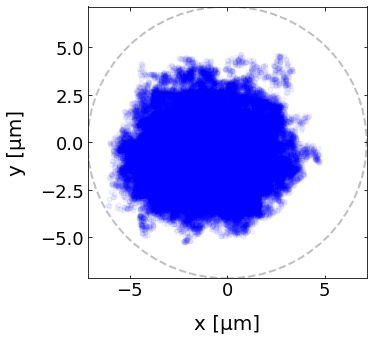

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
circle = plt.Circle((0, 0), rm*scale, color='0.75', lw=2, ls='--', fill=False)
ax.add_patch(circle)
ax.plot((f.x-xm)*scale, (f.y-ym)*scale, 'b.', alpha=0.05, ms=10)
ax.set_xlim(-rm*scale, rm*scale)
ax.set_ylim(-rm*scale, rm*scale)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
#plt.savefig('Position_Distribution_Overlay.png', dpi=300, bbox_inches='tight', pad_inches=0.025) # transparent=True
plt.show()

## Step size analysis

In [36]:
#f = f.sort_values(['particle', 'frame']) # orting for particel and frame if more than one particel is present

In [37]:
df = f[['x', 'y', 'particle', 'frame']].diff()
df['d'] = np.sqrt((f['x']-xm)**2 + (f['y']-ym)**2) # distance to center
# definining unit vectors in radial and tangential direction
df['er_x'] = (f['x']-xm)/df['d']
df['er_y'] = (f['y']-ym)/df['d']
df['et_x'] = (f['y']-ym)/df['d']
df['et_y'] = -(f['x']-xm)/df['d']
# append orientation
df['phi'] = f['orientation']
# keep only the deltas of the same particle
df = df[df['particle'] == 0]
# rename the columns
df.rename(columns={'x': 'dx', 'y': 'dy', 'frame': 'dframe'}, inplace=True)

In [38]:
# displacement vectors projected onto radial and tangential direction to the trap center
df['dr'] = (df['er_x']*df['dx'] + df['er_y']*df['dy'])/df['dframe']
df['dt'] = (df['et_x']*df['dx'] + df['et_y']*df['dy'])/df['dframe']

## Displacment histograms with respect to the orientation

In [39]:
# displacement vectors projected onto the orientation vector
df['ds'] = (np.sin(df['phi'])*df['dx'] + np.cos(df['phi'])*df['dy'])/df['dframe']
df['dp'] = (-np.cos(df['phi'])*df['dx'] + np.sin(df['phi'])*df['dy'])/df['dframe']

In [40]:
ds = np.array(df['ds'])
dp = np.array(df['dp'])

## Import height- and time-averaged temperature profile

In [48]:
xi, t_profile_mean= np.transpose(np.loadtxt(r'C:\Path to the following txt file\Temperature_Trap_Height-Time-Average_Profile.txt')) #this is one of two file you get out of the COMSOL calculations

In [49]:
def t_profile(r, alpha, t_center):
    return alpha/2*r**2 + t_center

ri = 5 # µm
ro = 6 # µm

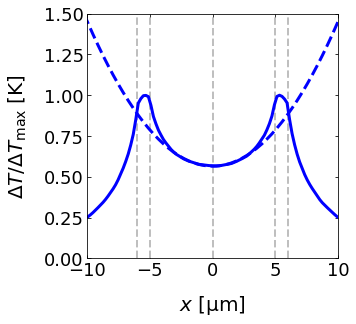

In [54]:
idx = np.where((xi > -3.5) & (xi < 3.5))
(alpha_rel, t_ratio), _ = curve_fit(t_profile, xi[idx], t_profile_mean[idx]) #, p0=[800,0,1] 

fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5))
ax.axvline(x=0, c='0.75', ls='--', lw=2)
ax.axvline(x=-ri, c='0.75', ls='--', lw=2)
ax.axvline(x=-ro, c='0.75', ls='--', lw=2)
ax.axvline(x=ri, c='0.75', ls='--', lw=2)
ax.axvline(x=ro, c='0.75', ls='--', lw=2)
plt.plot(xi, t_profile_mean, 'b', label='Time-Averaged')
ax.plot(xi, t_profile(xi, alpha_rel, t_ratio), c='b', ls='--')
ax.set_xlabel(r'$x$ [µm]')
ax.set_ylabel(r'$\Delta T/\Delta T_\mathrm{max}$ [K]')
ax.set_xlim(-10,10)
ax.set_ylim(0, 1.5);

In [120]:
print(f't_ratio = {t_ratio:.2}') # t_ratio = t_center/t_max

t_ratio = 0.56


In [122]:
print(f'alpha_rel = {alpha_rel:.2} 1/µm')

alpha_rel = 0.018 1/µm


## Radial position distribution

In [57]:
d = np.array(df['d'])

$P_\mathrm{R}(d) = S_\mathrm{T}\alpha\,d\,\mathrm{exp}\left(-\dfrac{S_\mathrm{T}\alpha}{2}d^2\right) \qquad \sigma^2 = 1/S_\mathrm{T}\alpha$

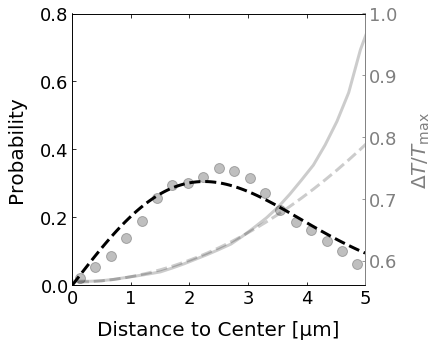

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.25,5))

# Histogram
bins = np.linspace(0,5,num=20)
hist_d, bin_edges = np.histogram(scale*d, bins = bins, density=True) #Density instead of normed since its decrepated

# Rayleigh fit
(a, sigma), _ = curve_fit(rayleigh, centers, hist_d) #, p0=[800,0,1]
fit_x = np.linspace(0, 5, 100)
fit_y = rayleigh(fit_x, a, sigma)

ax1.plot(centers, hist_d, 'o', c='k', alpha=0.25)
ax1.plot(fit_x, fit_y, 'k--', label='Rayleigh Dist.')

ax1.set_xlabel('Distance to Center [µm]')
ax1.set_ylabel('Probability')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.8)
#ax.legend()

# Temperature profile
ax2 = ax1.twinx()
ax2.plot(xi, t_profile(xi, alpha_rel, t_ratio), '--', c='k', alpha=0.2)
ax2.plot(xi, t_profile_mean, '-', c='k', alpha=0.2)
ax2.set_ylim(0.56, 1.0)
ax2.set_ylabel('$\Delta T/T_\mathrm{max}$', color='0.5')

ax2.spines['right'].set_color('0.5')
ax2.tick_params('y', colors='0.5')
ax1.spines['right'].set_color('0.5')
ax2.spines['right'].set_color('0.5')

plt.show()

### Temperature increment from experiments

See the Supplementary Note 4 for details.

In [131]:
t_center = 11.3
t_max = t_center/t_ratio
alpha = alpha_rel*t_max
print(f't_max = {t_max:.1f} K')
print(f'alpha = {alpha:.2} K/µm^2')

t_max = 20.0 K
alpha = 0.36 K/µm^2


### Soret coefficient from curvature

$S_\mathrm{T} = 1/(\sigma^2\alpha)$

In [135]:
ST = 1/(sigma**2*alpha)
print('ST = %.3f 1/K' % (ST))

ST = 286.381 1/K


## Step size distribution in radial and tangential direction

In [87]:
dr = np.array(df['dr'])
dt = np.array(df['dt'])

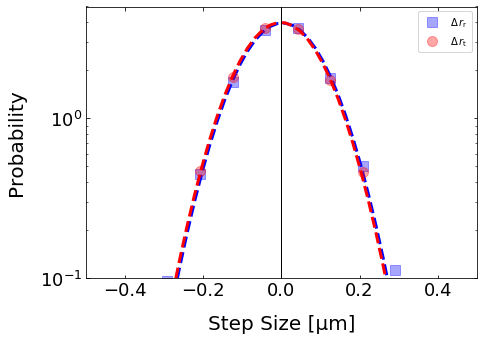

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bins = np.linspace(-1,1,25)
hist_dp, bin_edges = np.histogram(dr*scale, bins=bins, density=True)
hist_dt, _ = np.histogram(dt*scale, bins=bins, density=True)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

(a_s, x0_s, sigma_s), _ = curve_fit(gauss, centers, hist_dp) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_s, x0_s, sigma_s)
ax.plot(centers, hist_dp, 's', c='b', label='$\Delta\,r_\mathrm{r}$', alpha=0.35)
ax.plot(fit_x, fit_y, 'b--')

(a_p, x0_p, sigma_p), _ = curve_fit(gauss, centers, hist_dt) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_p, x0_p, sigma_p)

ax.plot(centers, hist_dt, 'o', c='r', label='$\Delta\,r_\mathrm{t}$', alpha=0.35)
ax.plot(fit_x, fit_y, c='r', ls='--')

ax.set_yscale('log')
#ax.set_ylim(ymin=0)
ax.axvline(0, c='k', ls='-', lw=1)
ax.set_ylim(0.1, 5)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('Step Size [µm]')
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend();
#plt.savefig('Radial_Tangential_Probability.pdf', bbox_inches='tight', pad_inches=0.025)

In [2]:
print(f'vT = {x0_s/exposure} µm/s') #Is the speed of the particle towards the center, induced by the Laser

NameError: name 'x0_s' is not defined

### Diffusion constant $D_\mathrm{t}$ from  tangential step size distribution

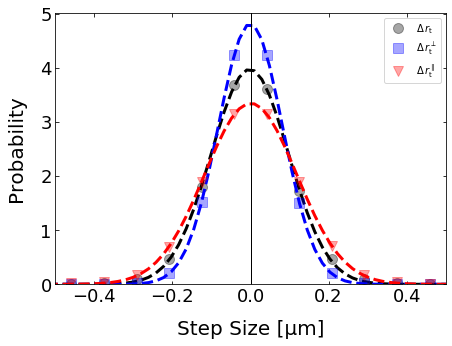

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# Histograms
nbins = 25
bins = np.linspace(-1,1,nbins)
hist_dt, bin_edges = np.histogram(dt*scale, bins=bins, density=True)
hist_ds, _ = np.histogram(ds*scale, bins=bins, density=True)
hist_dp, _ = np.histogram(dp*scale, bins=bins, density=True)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# Fits
(a, x0, sigma), _ = curve_fit(gauss, centers, hist_dt) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a, x0, sigma)
ax.plot(fit_x, fit_y, 'k--')
ax.plot(centers, hist_dt, 'o', c='k', label='$\Delta\,r_\mathrm{t}$', alpha=0.35)

(a_s, x0_s, sigma_s), _ = curve_fit(gauss, centers, hist_ds, p0=[1,0,1]) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_s, x0_s, sigma_s)
ax.plot(fit_x, fit_y, 'b--')
ax.plot(centers, hist_ds, 's', c='b', label='$\Delta\,r_\mathrm{t}^\perp$', alpha=0.35)

(a_p, x0_p, sigma_p), _ = curve_fit(gauss, centers, hist_dp, p0=[1,0,1]) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_p, x0_p, sigma_p)
ax.plot(fit_x, fit_y, c='r', ls='--')
ax.plot(centers, hist_dp, 'v', c='r', label='$\Delta\,r_\mathrm{t}^\parallel$',  alpha=0.35)

ax.axvline(0, c='k', ls='-', lw=1)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('Step Size [µm]')
ax.set_ylim(ymin=0)
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend()
#plt.savefig('../Figures/Step_Size_Translation.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

$D_\mathrm{t} = \sigma^2/(2\tau)$

In [100]:
Dt = sigma**2/(2*exposure)
print(f'Dt = {Dt:.3} µm^2/s')

Dt = 0.491 µm^2/s


In [102]:
Dt_p = sigma_p**2/(2*exposure)
print(f'Dt_p = {Dt_p:.3} µm^2/s')

Dt_s = sigma_s**2/(2*exposure)
print(f'Dt_s = {Dt_s:.3} µm^2/s')

Dt_p = 0.696 µm^2/s
Dt_s = 0.338 µm^2/s


In [103]:
print(f'Dt_s/Dt_p = {Dt_s/Dt_p:.3}')

Dt_s/Dt_p = 0.486


In [104]:
DT = ST*Dt
print(f'DT = {DT} µm^2/(K s)')

DT = 0.2722913296254022 µm^2/(K s)


## Drift velocity analyzed for different distances to the center

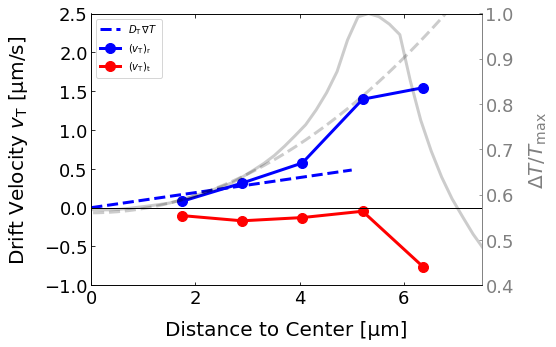

In [143]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
bins = 6
x = np.linspace(0,5,100)
y = DT*alpha*x
bin_means_dr, bin_edges, _ = stats.binned_statistic(scale*d, scale*dr, statistic='mean', bins=bins)
bin_means_dt, bin_edges, _ = stats.binned_statistic(scale*d, scale*dt, statistic='mean', bins=bins)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ax1.plot(x, y, 'b--', label=r'$D_\mathrm{T}\,\nabla T$', alpha=1)
ax1.plot(centers, bin_means_dr/exposure, 'bo-', alpha=1, label='$(v_\mathrm{T})_\mathrm{r}$')
ax1.plot(centers, bin_means_dt/exposure, 'ro-', alpha=1, label='$(v_\mathrm{T})_\mathrm{t}$')
ax1.axhline(0, c='k', ls='-', lw=1)
ax1.set_xlabel('Distance to Center [µm]')
ax1.set_xlim(0, 7.5)
ax1.set_ylabel('Drift Velocity $v_\mathrm{T}$ [µm/s]')
#ax.set_yticks(np.arange(-0.5, 2, 0.5))
ax1.set_ylim(-1, 2.5)
ax1.legend(loc='upper left') 

ax2 = ax1.twinx()
ax2.plot(xi, t_profile(xi, 0.019, 0.56), '--', c='k', alpha=0.2)
ax2.plot(xi, t_profile_mean, '-', c='k', alpha=0.2)
ax2.set_ylim(0.40, 1.0)
ax2.set_ylabel('$\Delta T/T_\mathrm{max}$', color='0.5')

ax2.spines['right'].set_color('0.5')
ax2.tick_params('y', colors='0.5')
ax1.spines['right'].set_color('0.5')
ax2.spines['right'].set_color('0.5')

#plt.savefig('Drift_Velocity.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

## Rotational diffusion

In [137]:
dphi = np.array(f[['orientation']].diff().dropna())

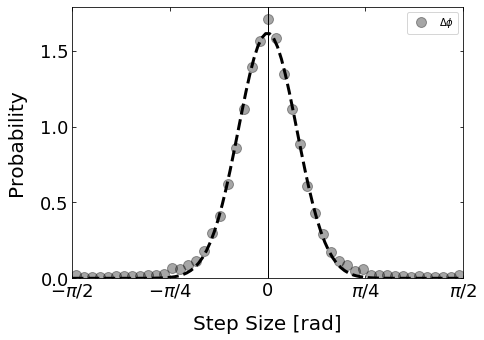

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# histogram
bins = np.linspace(-pi/2,pi/2,50)
hist_dphi, bin_edges = np.histogram(dphi, bins=bins, density=True)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit
(a, x0, sigma), _ = curve_fit(gauss, centers, hist_dphi) #, p0=[800,0,1]
fit_x = np.linspace(bins.min(), bins.max(), 100)
fit_y = gauss(fit_x, a, x0, sigma)

ax.plot(fit_x, fit_y, '--', c='k')
ax.plot(centers, hist_dphi, 'o', c='k', alpha=0.35, label='$\Delta\phi$') # /np.max(hist_dphi)

ax.axvline(0, c='k', ls='-', lw=1)
ax.set_xlim(bins.min(), bins.max())
ax.set_ylim(ymin=0)
ax.set_xticks([-0.5*np.pi, -0.25*np.pi, 0, 0.25*np.pi, 0.5*np.pi])
ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
ax.set_xlabel('Step Size [rad]')
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend()
#plt.savefig('../Figures/Step_Size_Rotation.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

$D_\mathrm{r} = \sigma^2/(2\tau)$

In [141]:
Dr_exp = sigma**2/(2*exposure)
print(f'Dr = {Dr_exp:.3f} rad^2/s')

Dr = 2.767 rad^2/s
